In [2]:
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
import csv
import matplotlib.pyplot as plt
from numpy import random
from collections import defaultdict
from tqdm.notebook import tqdm
from collections import Counter
from nltk.corpus import stopwords
from pandas import DataFrame
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import operator
import string
LOG_EVERY_N= 100

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
with open("passage_collection_new.txt", encoding= "utf8") as fp:
    passages = fp.read().split('\n')
    
with open("passage_collection_new.txt", encoding= "utf8") as fp:
    collection_words = fp.read().split()
    
TestQueriesdf = pd.read_csv("test-queries.tsv", sep="\t")
test_queries = TestQueriesdf.values

In [4]:
CandPassageTopdf = pd.read_csv("candidate_passages_top1000.tsv", sep="\t")
top_candidate_passages= CandPassageTopdf.values

with open("candidate_passages_top1000.tsv", encoding= "utf8") as fp:
    top_candidate_passages_words = fp.read().split("\n")


Subtask 1: 
Part1: Test Statistics and getting term frequencies

In [5]:
def GetTermFrequencies(passages_F):
    c=Counter('\n'.join(passages_F).lower().split())
    dictionary= dict(c)

    ranked_dictionary = [(dictionary[key], key) for key in dictionary] #sorting the values in a descening order
    ranked_dictionary.sort()
    ranked_dictionary.reverse()

    prob= np.zeros(len(ranked_dictionary))  

    ranked_dictionaryA= np.array(ranked_dictionary)
    freqs= [int(m) for m in ranked_dictionaryA[:,0]]
    freqs= np.array(freqs)

    probs= freqs / len(collection_words)                    #Calculating probabilities too
    r= range(1,len(ranked_dictionary)+1)

    return ranked_dictionary, probs, r


In [6]:
SortedDictionary, prob, r= GetTermFrequencies(passages)

mean C parameter is:  0.094


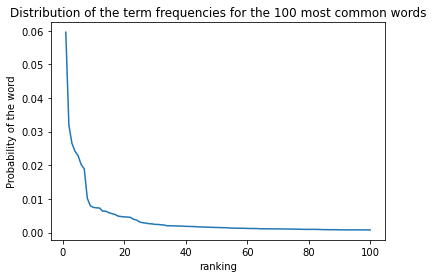

In [209]:
c_parameter= np.mean(r[0:10000]*prob[0:10000])
print("mean C parameter is: ", round(c_parameter,3))
plt.plot(r[0:100], prob[0:100])                       #most 50 frequent
plt.ylabel('Probability of the word')
plt.xlabel('ranking')
plt.title('Distribution of the term frequencies for the 100 most common words')
plt.show()

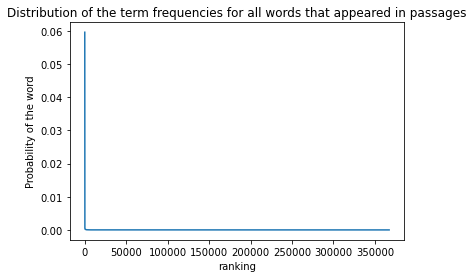

In [213]:
plt.plot(r, prob)                       
plt.ylabel('Probability of the word')
plt.xlabel('ranking')
plt.title('Distribution of the term frequencies for all words that appeared in passages')
plt.show()

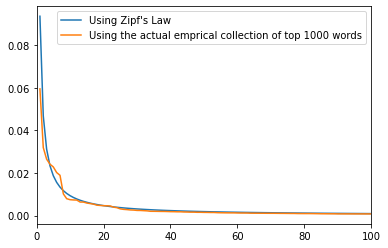

In [211]:
prob_zipf= np.zeros(len(SortedDictionary))
prob_zipf= c_parameter/r
plt.plot(r[0:100],prob_zipf[0:100])
plt.plot(r[0:100],prob[0:100]) 
plt.xlim([0, 100])
plt.legend(["Using Zipf's Law", "Using the actual emprical collection of top 1000 words"], loc ="upper right")
plt.show()

Part2: Doing PreProcessing before inverse indexing

In [10]:
def removeStopwords(wordlists, stopwords):            # function that removes stop words
    filtered_list= []
    LOG_EVERY_N= 10000
    for i in range(len(wordlists)):
        wordL= wordlists[i].lower().split()                  #Split into every word
        removal = [w for w in wordL if w not in stop_words]  # remove stopwords by Iteratively going through them
        temp=0
        temp= ' '.join(removal)
        filtered_list.append(temp)
    
    return filtered_list

In [11]:
def LemmatizeWords(wordlists):
    lemmatized_filtered_passages= []
    LOG_EVERY_N= 10000
    wordnet_lemmatizer = WordNetLemmatizer()
    for j in range(len(wordlists)):
        filteredL= wordlists[j].split()
        lemmatizing= [wordnet_lemmatizer.lemmatize(word) for word in filteredL]
        temp = 0
        temp= ' '.join(lemmatizing)
        lemmatized_filtered_passages.append(temp)
    return lemmatized_filtered_passages

In [12]:
def removepunct(wordlists): 
    no_punct_list= []
    LOG_EVERY_N= 10000
    for i in range(len(wordlists)):
        wordL= wordlists[i].lower()                 #Split into every word
        removal = wordL.translate(str.maketrans('', '', string.punctuation))
        no_punct_list.append(removal)   
    return no_punct_list

In [241]:
stop_words= stopwords.words('english')
  #remove punctuation
filtered_passages= removeStopwords(top_candidate_passages[:,3], stop_words)
lemmed_filtered_passages= removepunct(filtered_passages)
lemmed_filtered_passages= LemmatizeWords(lemmed_filtered_passages)
lemmed_filtered_words= '\n'.join(lemmed_filtered_passages).split()


PreProcessing the text queries

In [220]:
filtered_test_queries=removeStopwords(test_queries[:,1], stop_words)
lemmed_filtered_test_queries= removepunct(filtered_test_queries)
lemmed_filtered_test_queries=LemmatizeWords(lemmed_filtered_test_queries)


In [88]:
#print("Before removing stop words and lemmatizing: \n")  #Lemmatizing is better
#print(test_queries[0,1])
#print("\n")
#print("After removing stop words and lemmatizing: \n")
#print(lemmed_filtered_test_queries[0])
#print("\n")
#print("Before removing stop words and lemmatizing: \n")
#print(test_queries[10,1])
#print("\n")
#print("After removing stop words and lemmatizing: \n")
#print(lemmed_filtered_test_queries[10])


PreProcessing the Text in the candidate text file (candidate_passages_top1000.tsv) file

In [221]:
query_ids= test_queries[:,0]
temp= []
filtered_passages_per_query= []
passages_id_per_query= []
for j in range(len(query_ids)):
    indices = [i for i, x in enumerate(top_candidate_passages[:,0]) if x == query_ids[j]]
    temp_passages=top_candidate_passages[indices,3]
    temp_id= top_candidate_passages[indices,1]
    filt= removeStopwords(temp_passages, stop_words)
    lemm= removepunct(filt)
    temp_passages= LemmatizeWords(lemm)
    filtered_passages_per_query.append(temp_passages)
    passages_id_per_query.append(temp_id)


Question 2: Building the Nested Inverted index:

In [222]:
InvIndx= dict({qid: { } for qid in query_ids})
for i in range(len(query_ids)):
    query_words= lemmed_filtered_test_queries[i].split()
    for j in range(len(filtered_passages_per_query[i])):
        check = filtered_passages_per_query[i][j]     
        for item in query_words: 
            if item in check:
                occurance=check.count(item)
                if item not in InvIndx[query_ids[i]]:
                    InvIndx[query_ids[i]][item] = []    
                if item in InvIndx[query_ids[i]]:
                    InvIndx[query_ids[i]][item].append(passages_id_per_query[i][j])
                InvIndx[query_ids[i]][item].append(occurance) 


In [89]:
#print("Example of checking correctness:")
#queryids= list(InvIndx.keys())
#print("Random Query ID: ",queryids[9])
#print("Query text related to ID: ", top_candidate_passages[list(top_candidate_passages[:,0]).index(queryids[9]),2])
#wordsinquery= list(InvIndx[queryids[9]].keys())
#print("Filtered and Lemmatized Words in the Query: ", wordsinquery)
#print("picking one word: ", wordsinquery[2])
#values= list(InvIndx[queryids[9]][wordsinquery[2]])
#print("Looking at one instance of a passage where the InvIndxtionary states that a word was mentioned n times in that passage with the ID: ", values[0:2])

#print("The passage: \n")
#print(top_candidate_passages[np.where(top_candidate_passages[:,1]==values[0]),3])


Question 3 and 4 Combined: Retrieval Models

In [242]:
TF_IDF= np.zeros((len(filtered_passages_per_query),len(filtered_passages_per_query[0])))

BM25= np.zeros((len(filtered_passages_per_query),len(filtered_passages_per_query[0])))

V_space= np.zeros((len(filtered_passages_per_query),len(filtered_passages_per_query[0])))

LM_Dirichlet= np.zeros((len(filtered_passages_per_query),len(filtered_passages_per_query[0])))

LM_LaPlace= np.zeros((len(filtered_passages_per_query),len(filtered_passages_per_query[0])))

LM_Lidstone= np.zeros((len(filtered_passages_per_query),len(filtered_passages_per_query[0])))



words = ''.join(str(filtered_passages_per_query[:][:])).split()

no_of_words= len(words)

vocab_size= len(list(InvIndx.fromkeys(words))) 

no_of_documents = len(filtered_passages_per_query) * len(filtered_passages_per_query[0])

average_doc_length =  no_of_words / no_of_documents

ri= 0
R= 0
k1= 1.2
k2= 100
b=0.75
mu= 2000
epsilon= 0.5
print(average_doc_length)

32.63633165829146


Bulk of code where all the retrieval models were generated:

In [224]:

for q in range(len(filtered_passages_per_query)):                 # Iterating Through each query
    
    N_total= len(filtered_passages_per_query) * len(filtered_passages_per_query[q])            #Total Number of documents in collection
    words_in_query= list(InvIndx[queryids[q]].keys())       # Find the words available for every query
    
    for d in range(len(filtered_passages_per_query[q])):                     #Iterating through every document
        
        doc_len= len(filtered_passages_per_query[q][d].split())
        query_len= len(words_in_query) 
        doc_id= passages_id_per_query[q][d]                                         # getting the document id
        K= k1* ((1-b) + (b * ((doc_len)/average_doc_length)))
        
          
        FProd_td_idf=1
        FProd_V_space=1 
        
        summation_BM = 0
        summation_LM_Dirichlet = 0 
        summation_LM_Lidstone = 0  
        summation_LM_LaPlace = 0
        
        
        
        for t in range(len(words_in_query)):                   #For each word in the query  
            
            values= list(InvIndx[queryids[q]][words_in_query[t]])  #Inverted index for term position and frequency
            nt= int(len(values)/2)                              # how many docs has it occured in
            num1=0.5
            denum1=0.5
            num2= nt+0.5
            denum2=N_total- nt + 0.5

            
            if doc_id in values: 
                
                tf = values[values.index(doc_id) + 1]                       # Term frequency in that document
                
                try:
                    product1_BM= np.log((num1/denum1) / (num2/denum2))                             #First Part od BM
                except ZeroDivisionError:
                    product1_BM = 1                              # 1 as its a log
                
                product2_BM= ((k1+1) * tf) / (K+tf)
                product3_BM= ((k2+1)*words_in_query.count(words_in_query[t])) / (k2+words_in_query.count(words_in_query[t]))
                
                  
                Product_BM= product1_BM * product2_BM * product3_BM 
                
                tf_idf= (tf * np.log(N_total/nt))
                Product_Vspace=  tf_idf / (doc_len * query_len)
                
                #I normalised all smoothing techniques as its still proportional plus numbers are easier to see
                Product_Lidstone= np.log((tf + epsilon) / (doc_len + (epsilon*vocab_size)))
                Product_LaPlace= np.log((tf+1) / (doc_len + vocab_size))
                Product_Dirichlet = np.log((((doc_len/(doc_len+mu))*(tf/doc_len)))+(((mu/(mu+doc_len))*(nt/vocab_size)))) 
                
            else:
                # If terms are not seen
                Product_BM=0
                tf_idf=1
                Product_Vspace= 1
                Product_Lidstone= np.log(epsilon / (doc_len + (epsilon*vocab_size)))   
                Product_LaPlace= np.log(1 / (doc_len + vocab_size))
                Product_Dirichlet = np.log((mu/(mu+doc_len))*(nt/vocab_size))

                
                
            FProd_td_idf*= (tf * np.log(N_total/nt))
            FProd_V_space*= Product_Vspace
            
            summation_BM+= Product_BM 
            summation_LM_Lidstone+=Product_Lidstone
            summation_LM_Dirichlet+= Product_Dirichlet
            summation_LM_LaPlace+=Product_LaPlace
                
        
        TF_IDF[q,d]= FProd_td_idf
        V_space[q,d]= FProd_V_space
        BM25[q,d]=summation_BM
        LM_Lidstone[q,d]=summation_LM_Lidstone
        LM_Dirichlet[q,d]=summation_LM_Dirichlet    
        LM_LaPlace[q,d]= summation_LM_LaPlace 
        
        

In [23]:
#print("TF-IDF Vector Representation is as follows: \n")

#print(TF_IDF)

In [225]:
for i in range(LM_Dirichlet.shape[0]):
    for j in range(LM_Dirichlet.shape[1]):
        if LM_Dirichlet[i,j] == 0:
            LM_Dirichlet[i,j]= -100 
            LM_Lidstone[i,j]= -100 
            LM_LaPlace[i,j]= -100 

Generating the re-ranking and saving the files:

In [226]:
def GenerateNRanking(total_list,N,passages_id_per_query,query_ids):
    N=100
    total_qid= []
    total_pids= []
    total_scores= []
    total_doc_indices = []
    
    for qu in range(len(total_list)):          # For every Query
        scores = []
        qid= []
        pids = []
        list1= list(total_list[qu,:])       # Get the scores
        for i in range(0,N):                # Find top 100 scores
            max1= np.max(list1)
            if (max1==-100 or max1== 0):
                list1.remove(max1)
                scores.append(["NaN"])
                pids.append(["NaN"])
                qid.append(["NaN"]) 
            else:
                document_index= 0
                document_index= list(list1).index(max1)
                list1.remove(max1)
                scores.append(max1)
                pids.append(passages_id_per_query[qu][document_index])
                qid.append(query_ids[qu])
        total_scores.append(scores)
        total_pids.append(pids)
        total_qid.append(qid)
    return total_scores,total_qid, total_pids

In [180]:
def SaveFile(total_scores,total_qid,total_pids,algo):
    
    
    qids= np.array(total_qid)
    qids=qids.reshape((qids.shape[0]*qids.shape[1],1))
    
    pids= np.array(total_pids)
    pids= pids.reshape((pids.shape[0]*pids.shape[1],1))
    
    scores= np.array(total_scores)
    scores=scores.reshape((scores.shape[0]*scores.shape[1],1))
    
    
    
    algor= np.full((qids.shape[0], 1), algo) 
    watermark= np.full((qids.shape[0], 1), "A1")                 #Watermark
      
    ranking= np.array((range(1,len(total_pids[0])+1)))
    ranklist = []
    for x in range(len(total_pids)):
        ranklist.append(ranking)  
        
    rank = np.array(ranklist)  
    rank = rank.reshape((rank.shape[0]*rank.shape[1],1))
    
    with open('%s.txt' % algo,'w+') as f:
        writer= csv.writer(f,)
        writer.writerows(zip(qids,watermark,pids,rank,scores,algor))

In [227]:
#BM25
total_scores,total_qid,total_pids = GenerateNRanking(BM25,N,passages_id_per_query,query_ids)

In [228]:
#VS 
total_scores_VS,total_qid_VS,total_pids_VS= GenerateNRanking(V_space,N,passages_id_per_query,query_ids)

In [229]:
#Dirichlet
total_scores_Dir,total_qid_Dir,total_pids_Dir= GenerateNRanking(LM_Dirichlet,N,passages_id_per_query,query_ids)

In [230]:
#Lidstone
total_scores_Lid,total_qid_Lid,total_pids_Lid= GenerateNRanking(LM_Lidstone,N,passages_id_per_query,query_ids)

In [231]:
#LaPlace
total_scores_LP, total_qid_LP,total_pids_LP = GenerateNRanking(LM_LaPlace,N,passages_id_per_query,query_ids)

In [236]:
SaveFile(total_scores,total_qid,total_pids,"BM25")

In [237]:
SaveFile(total_scores_VS,total_qid_VS,total_pids_VS,"VS")

In [238]:
SaveFile(total_scores_Dir,total_qid_Dir,total_pids_Dir,"LM-Dirichlet")

In [239]:
SaveFile(total_scores_Lid,total_qid_Lid,total_pids_Lid,"LM-Lidstone")

In [240]:
SaveFile(total_scores_LP,total_qid_LP,total_pids_LP,"LM-LaPlace")

In [245]:
Compare= 11


print("Query: ")
print(test_queries[np.where(test_queries[:,0]==total_qid[Compare][0]),1])
print("\n")
print("Top BM25 on txt file: ")
print(top_candidate_passages[np.where(top_candidate_passages[:,1]==total_pids[Compare][0]),3])
print("\n")
print("Top VS on txt file: ")
print(top_candidate_passages[np.where(top_candidate_passages[:,1]==total_pids_VS[Compare][0]),3])
print("\n")
print("Top Laplace on txt file: ")
print(top_candidate_passages[np.where(top_candidate_passages[:,1]==total_pids_LP[Compare][0]),3])
print("\n")
print("Top Lidstone on txt file: ")
print(top_candidate_passages[np.where(top_candidate_passages[:,1]==total_pids_Lid[Compare][0]),3])
print("\n")
print("Top Dirichlet on txt file: ")
print(top_candidate_passages[np.where(top_candidate_passages[:,1]==total_pids_Dir[Compare][0]),3])


Query: 
[["sop's policy"]]


Top BM25 on txt file: 
[["To establish the standard operating procedure (SOP) for soldiers on Extra Duty within the unit. » Awards SOP. All award recommendations will be prepared in accordance with the examples in this SOP, and forwarded to the Company Commander through the First Sergeant for recommendation and signature. » Alcohol and Drug Policy Letter. This commander's policy letter establishes the alcohol policy for this command."]]


Top VS on txt file: 
[['Meaning; SOP: Standard Operating Procedure: SOP: Soprano: SOP: Statement Of Position']]


Top Laplace on txt file: 
[["To establish the standard operating procedure (SOP) for soldiers on Extra Duty within the unit. » Awards SOP. All award recommendations will be prepared in accordance with the examples in this SOP, and forwarded to the Company Commander through the First Sergeant for recommendation and signature. » Alcohol and Drug Policy Letter. This commander's policy letter establishes the alcoho